# Generate list of possible motifs
* Build BED for intron and upstream region
* intersect with fimo output from the entire genome for each of the 5 motif databases
* take fdr of pvalues
* concat datasets??? 

In [69]:
import gffutils
from gffutils import pybedtools_integration
import pybedtools
from pybedtools.featurefuncs import gff2bed
import pandas as pd
import seaborn as sb
import statsmodels
import statsmodels.api as sm
%matplotlib inline

I first use gffutils to get introns plus 1kb upstream of transcripts:

In [4]:
db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.gtf.db')

/Users/bergeric/miniconda3/lib/python3.5/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


In [5]:
idb = gffutils.create_db(db.create_introns(), ":memory:")

In [6]:
for a in idb.featuretypes():
    print(a)

intron


In [8]:
ibed = pybedtools_integration.to_bedtool(idb.features_of_type('intron')).saveas('../../data/dm6_introns.bed')

- get exons, then merge them
- subtract from gene to get introns
- slop transcripts
- subtract transcripts from slopped transcripts to get just upstream
- cat slop with introns

In [9]:
exons = pybedtools_integration.to_bedtool(db.features_of_type('exon')).saveas()

In [22]:
exonmerge = exons.sort().merge().saveas('../../data/dm6_exons.bed') #need to figure this out

In [29]:
genes = pybedtools_integration.to_bedtool(db.features_of_type('gene')).saveas('../../data/dm6_genes.gtf')
genes = genes.sort().merge().saveas()

In [30]:
introns = genes.subtract(exonmerge).saveas('../../data/dm6_introns_3rdway.bed')

In [14]:
transcripts = pybedtools_integration.to_bedtool(db.features_of_type('transcript')).saveas()

In [15]:
slopped = transcripts.slop(b=1000, s=True, genome='dm6').saveas()

In [16]:
diff = slopped.subtract(transcripts, s=True)

In [32]:
#woo Justin says looks good
intslop = diff.cat(introns).saveas('../../data/dm6_intron_sloptranscript.bed')

Now I have my regions, need to intersect with fimo outputs from each database: 

This is annoying since I had to copy over all from biowulf but I can fix the paths later

# dmmpmm

First, read in fimo for whole genome. I'm currently unsure if I want to bother with this gff2bed step or just use my parser, since I need the pvalue information which is lost in gff2bed. 

In [33]:
#read in fimo for whole genome
fimo = pybedtools.BedTool('../../data/fimo_frombiowulf/motif_alignments_dmmpmm2009_dm6.gff')
fimo_bed = fimo.each(gff2bed, name_field='Name').saveas()
fimodf = fimo_bed.to_dataframe()
fimo_bed_df = fimodf.join(dmm_df, how='inner', rsuffix='_r')[['chrom','start','end','name', 'pvalue','strand']]
#fimo_bed_df.to_csv('../../data/dmmpmm.bed', sep='\t', header=None, index=False)

Here's my parser: (only problem is its going to be slower for the big files)

In [131]:
table = []
with open('../../data/fimo_frombiowulf/motif_alignments_dmmpmm2009_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            chrom = broken[0]
            strand = broken[6]
            stuff = (chrom, start, end, TF, strand, pval, qval)
            table.append(stuff)
            
new_df_dmm= pd.DataFrame(table, columns=['chrom','start','end','name', 'strand', 'pvalue', 'qvalue'])

In [174]:
dmm_df = new_df_dmm[['chrom','start','end', 'name', 'strand','pvalue']]
#add column for motif_FBgn
symbolmap = pd.read_table('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.SYMBOL.csv', sep=',') 
addcol = dmm_df.merge(symbolmap, left_on='name', right_on='SYMBOL', how='left')
addcol[['chrom','start','end','name','strand','pvalue','ENSEMBL']].to_csv('../../data/dmmpmm.bed', sep='\t', header=None, index=False)

In [175]:
dm_intersect = pybedtools.BedTool('../../data/dmmpmm.bed').intersect(intslop, wb=True).saveas().to_dataframe()

In [176]:
dm_intersect.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr2L,278605,278612,bcd,+,0.000014,FBgn0000166,chr2L,278234,279234
1,chr2L,383877,383884,bcd,+,0.000014,FBgn0000166,chr2L,378481,384510
2,chr2L,579770,579777,bcd,+,0.000014,FBgn0000166,chr2L,579549,580549
3,chr2L,683479,683486,bcd,+,0.000014,FBgn0000166,chr2L,657384,705870
4,chr2L,1222849,1222856,bcd,+,0.000014,FBgn0000166,chr2L,1220035,1227701


In [177]:
dm_frame = dm_intersect[['chrom','start','end','score','strand','name','thickStart']]
dm_frame.columns = ['chrom','start','end','strand', 'pval','motif_symbol','motif_FBgn']
dm_frame.head()

,chrom,start,end,strand,pval,motif_symbol,motif_FBgn
0,chr2L,278605,278612,+,0.000014,bcd,FBgn0000166
1,chr2L,383877,383884,+,0.000014,bcd,FBgn0000166
2,chr2L,579770,579777,+,0.000014,bcd,FBgn0000166
3,chr2L,683479,683486,+,0.000014,bcd,FBgn0000166
4,chr2L,1222849,1222856,+,0.000014,bcd,FBgn0000166


In [138]:
#I don't know why this module is weird depending on if I run in biowulf or my comp??? 
#Biowulf: 
#pvals_c = statsmodels.sandbox.stats.multicomp.multipletests(less_big.pval, alpha=.01, method='fdr_bh')[1]
#my comp: 
dm_pvals_c= sm.stats.multipletests(dm_frame.pval.values, alpha=.01, method='fdr_bh')[1]

In [139]:
dm_frame_copy = dm_frame.copy()

In [140]:
dm_frame_copy['FDR'] = list(pvals_c)

In [141]:
dm_frame_copy.head()

,chrom,start,end,name,strand,pval,intron_start,intron_end,FDR
0,chr2L,278605,278612,bcd,+,0.000014,278234,279234,0.000099
1,chr2L,383877,383884,bcd,+,0.000014,378481,384510,0.000099
2,chr2L,579770,579777,bcd,+,0.000014,579549,580549,0.000099
3,chr2L,683479,683486,bcd,+,0.000014,657384,705870,0.000099
4,chr2L,1222849,1222856,bcd,+,0.000014,1220035,1227701,0.000099


In [142]:
new_df_dmm.head()

,chrom,start,end,name,strand,pvalue,qvalue
0,chr2L,83874,83881,bcd,+,0.000014,1.0
1,chr2L,278605,278612,bcd,+,0.000014,1.0
2,chr2L,383877,383884,bcd,+,0.000014,1.0
3,chr2L,405798,405805,bcd,+,0.000014,1.0
4,chr2L,554220,554227,bcd,+,0.000014,1.0


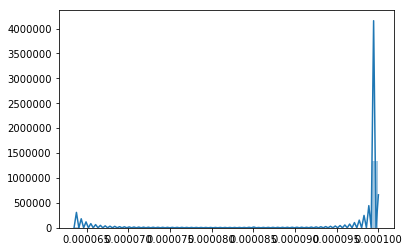

In [143]:
sb.distplot(pvals_c)

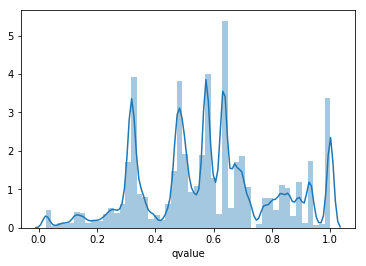

In [144]:
sb.distplot(new_df.qvalue)

In [42]:
#not using anymore but keeping here: 
#from qvalue import qvalue
#qvalue.estimate(less_big.pval)

# flyReg

In [145]:
table = []
with open('../../data/fimo_frombiowulf/motif_alignments_flyReg_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            chrom = broken[0]
            strand = broken[6]
            stuff = (chrom, start, end, TF, strand, pval, qval)
            table.append(stuff)
            
new_df_flyReg= pd.DataFrame(table, columns=['chrom','start','end','name', 'strand', 'pvalue', 'qvalue'])

In [166]:
flyReg_df = new_df_flyReg[['chrom','start','end', 'name', 'strand','pvalue']]

In [170]:
#add column for motif_FBgn
symbolmap = pd.read_table('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.SYMBOL.csv', sep=',') 
addcol = flyReg_df.merge(symbolmap, left_on='name', right_on='SYMBOL', how='left')
addcol[['chrom','start','end','name','strand','pvalue','ENSEMBL']].to_csv('../../data/flyReg.bed', sep='\t', header=None, index=False)

In [171]:
fR_intersect = pybedtools.BedTool('../../data/flyReg.bed').intersect(intslop, wb=True).saveas().to_dataframe()

In [172]:
fR_intersect.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr2L,57297,57304,abd-A,+,0.000026,FBgn0000014,chr2L,55767,58080
1,chr2L,77833,77840,abd-A,+,0.000026,FBgn0000014,chr2L,77783,78783
2,chr2L,81797,81804,abd-A,+,0.000026,FBgn0000014,chr2L,81420,82420
3,chr2L,109268,109275,abd-A,+,0.000026,FBgn0000014,chr2L,108809,109593
4,chr2L,177022,177029,abd-A,+,0.000026,FBgn0000014,chr2L,175447,182819


In [173]:
fR_frame = fR_intersect[['chrom','start','end','score','strand','name','thickStart']]
fR_frame.columns = ['chrom','start','end','strand', 'pval','motif_symbol','motif_FBgn']
fR_frame.head()

,chrom,start,end,strand,pval,motif_symbol,motif_FBgn
0,chr2L,57297,57304,+,0.000026,abd-A,FBgn0000014
1,chr2L,77833,77840,+,0.000026,abd-A,FBgn0000014
2,chr2L,81797,81804,+,0.000026,abd-A,FBgn0000014
3,chr2L,109268,109275,+,0.000026,abd-A,FBgn0000014
4,chr2L,177022,177029,+,0.000026,abd-A,FBgn0000014


In [150]:
#I don't know why this module is weird depending on if I run in biowulf or my comp??? 
#Biowulf: 
#pvals_c = statsmodels.sandbox.stats.multicomp.multipletests(less_big.pval, alpha=.01, method='fdr_bh')[1]
#my comp: 
fR_pvals_c= sm.stats.multipletests(fR_frame.pval.values, alpha=.01, method='fdr_bh')[1]

In [151]:
fR_frame_copy = fR_frame.copy()
fR_frame_copy['FDR'] = list(fR_pvals_c)

In [152]:
fR_frame_copy.head()

,chrom,start,end,name,strand,pval,intron_start,intron_end,FDR
0,chr2L,57297,57304,abd-A,+,0.000026,55767,58080,0.000095
1,chr2L,77833,77840,abd-A,+,0.000026,77783,78783,0.000095
2,chr2L,81797,81804,abd-A,+,0.000026,81420,82420,0.000095
3,chr2L,109268,109275,abd-A,+,0.000026,108809,109593,0.000095
4,chr2L,177022,177029,abd-A,+,0.000026,175447,182819,0.000095


# idmmpmm

In [103]:
table = []
with open('../../data/fimo_frombiowulf/motif_alignments_idmmpmm2009_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            chrom = broken[0]
            strand = broken[6]
            stuff = (chrom, start, end, TF, strand, pval, qval)
            table.append(stuff)
            
new_df_idm= pd.DataFrame(table, columns=['chrom','start','end','name', 'strand', 'pvalue', 'qvalue'])

In [178]:
idm_df = new_df_idm[['chrom','start','end', 'name', 'strand','pvalue']]
#add column for motif_FBgn 
addcol = idm_df.merge(symbolmap, left_on='name', right_on='SYMBOL', how='left')
addcol[['chrom','start','end','name','strand','pvalue','ENSEMBL']].to_csv('../../data/idm.bed', sep='\t', header=None, index=False)

In [179]:
idm_intersect = pybedtools.BedTool('../../data/idm.bed').intersect(intslop, wb=True).saveas().to_dataframe()
idm_intersect.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr2L,18750,18757,abd-A,+,0.000036,FBgn0000014,chr2L,18570,19879
1,chr2L,74856,74863,abd-A,+,0.000036,FBgn0000014,chr2L,73836,74902
2,chr2L,182087,182094,abd-A,+,0.000036,FBgn0000014,chr2L,175447,182819
3,chr2L,203402,203409,abd-A,+,0.000036,FBgn0000014,chr2L,203397,204742
4,chr2L,255769,255776,abd-A,+,0.000036,FBgn0000014,chr2L,254750,259948


In [180]:
idm_frame = idm_intersect[['chrom','start','end','score','strand','name','thickStart']]
idm_frame.columns = ['chrom','start','end','strand', 'pval','motif_symbol','motif_FBgn']
idm_frame.head()

,chrom,start,end,strand,pval,motif_symbol,motif_FBgn
0,chr2L,18750,18757,+,0.000036,abd-A,FBgn0000014
1,chr2L,74856,74863,+,0.000036,abd-A,FBgn0000014
2,chr2L,182087,182094,+,0.000036,abd-A,FBgn0000014
3,chr2L,203402,203409,+,0.000036,abd-A,FBgn0000014
4,chr2L,255769,255776,+,0.000036,abd-A,FBgn0000014


In [115]:
#I don't know why this module is weird depending on if I run in biowulf or my comp??? 
#Biowulf: 
#pvals_c = statsmodels.sandbox.stats.multicomp.multipletests(less_big.pval, alpha=.01, method='fdr_bh')[1]
#my comp: 
idm_pvals_c= sm.stats.multipletests(idm_frame.pval.values, alpha=.01, method='fdr_bh')[1]

In [129]:
idm_frame_copy = idm_frame.copy()
idm_frame_copy['FDR'] = list(idm_pvals_c)

In [159]:
idm_frame_copy.to_csv('../../data/idmintersect.bed', sep='\t', header=None, index=False)

# onTheFly

In [119]:
table = []
with open('../../data/fimo_frombiowulf/motif_alignments_onTheFly_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            chrom = broken[0]
            strand = broken[6]
            stuff = (chrom, start, end, TF, strand, pval, qval)
            table.append(stuff)
            
new_df_oTF= pd.DataFrame(table, columns=['chrom','start','end','name', 'strand', 'pvalue', 'qvalue'])

In [192]:
oTF_df = new_df_oTF[['chrom','start','end', 'name', 'strand','pvalue']]
#add column for motif_FBGN
otfmap = pd.read_table('../../output/onTheFlyMap.tsv')
y = otfmap[['name', 'FBgn']]
update = oTF_df.merge(y, on='name', how='left')
#add column for motif_symbol
#do I need this? 
symbolmap = pd.read_table('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.SYMBOL.csv', sep=',', na_values='NA', keep_default_na=False) 
newmap = symbolmap.drop_duplicates(subset='ENSEMBL', keep='first')
updateagain = update.merge(newmap, left_on='FBgn', right_on='ENSEMBL', how='left')

In [194]:
updateagain[['chrom','start','end','SYMBOL','strand','pvalue','FBgn']].to_csv('../../data/oTF.bed', sep='\t', header=None, index=False)

In [195]:
oTF_intersect = pybedtools.BedTool('../../data/oTF.bed').intersect(intslop, wb=True).saveas().to_dataframe()
oTF_intersect.head()

/Users/bergeric/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr2L,61940,61946,svp,-,0.000066,FBgn0003651,chr2L,59268,66404
1,chr2L,116733,116739,svp,-,0.000066,FBgn0003651,chr2L,116488,116969
2,chr2L,228672,228678,svp,-,0.000066,FBgn0003651,chr2L,228588,229929
3,chr2L,308315,308321,svp,-,0.000066,FBgn0003651,chr2L,306389,308536
4,chr2L,317447,317453,svp,-,0.000066,FBgn0003651,chr2L,310605,318361


In [196]:
oTF_frame = oTF_intersect[['chrom','start','end','score','strand','name','thickStart']]
oTF_frame.columns = ['chrom','start','end','strand', 'pval','motif_symbol','motif_FBgn']
oTF_frame.head()

,chrom,start,end,strand,pval,motif_symbol,motif_FBgn
0,chr2L,61940,61946,-,0.000066,svp,FBgn0003651
1,chr2L,116733,116739,-,0.000066,svp,FBgn0003651
2,chr2L,228672,228678,-,0.000066,svp,FBgn0003651
3,chr2L,308315,308321,-,0.000066,svp,FBgn0003651
4,chr2L,317447,317453,-,0.000066,svp,FBgn0003651


In [123]:
#I don't know why this module is weird depending on if I run in biowulf or my comp??? 
#Biowulf: 
#pvals_c = statsmodels.sandbox.stats.multicomp.multipletests(less_big.pval, alpha=.01, method='fdr_bh')[1]
#my comp: 
oTF_pvals_c= sm.stats.multipletests(oTF_frame.pval.values, alpha=.01, method='fdr_bh')[1]

In [127]:
oTF_frame_copy = oTF_frame.copy()
oTF_frame_copy['FDR'] = list(oTF_pvals_c)

In [128]:
oTF_frame_copy.head()

,chrom,start,end,name,strand,pval,intron_start,intron_end,FDR
0,chr2L,61940,61946,OTF0001.1,-,0.000066,59268,66404,0.000097
1,chr2L,116733,116739,OTF0001.1,-,0.000066,116488,116969,0.000097
2,chr2L,228672,228678,OTF0001.1,-,0.000066,228588,229929,0.000097
3,chr2L,308315,308321,OTF0001.1,-,0.000066,306389,308536,0.000097
4,chr2L,317447,317453,OTF0001.1,-,0.000066,310605,318361,0.000097


# flyFactor

needs to finish fimo

once I have all of these ``` <database>_frame``` s, do a concat. Then,
- Combine fimo datasets from all motif databases.
- Remove duplicate entries due to a TF being present in multiple databases.

In [229]:
#FDR is only in the _copy frames so I'll just use the non copied ones: 
concat = [dm_frame, fR_frame, oTF_frame, idm_frame] #at some point add fF_frame
alldatabases = pd.concat(concat)

In [230]:
alldatabases.head()

,chrom,start,end,strand,pval,motif_symbol,motif_FBgn
0,chr2L,278605,278612,+,0.000014,bcd,FBgn0000166
1,chr2L,383877,383884,+,0.000014,bcd,FBgn0000166
2,chr2L,579770,579777,+,0.000014,bcd,FBgn0000166
3,chr2L,683479,683486,+,0.000014,bcd,FBgn0000166
4,chr2L,1222849,1222856,+,0.000014,bcd,FBgn0000166


In [209]:
grp = alldatabases.groupby(['motif_symbol','motif_FBgn','chrom','strand'])

In [234]:
alldata = pybedtools.BedTool.from_dataframe(alldatabases).saveas('../../data/alldatabases.bed')

In [238]:
alldatabases.loc[24239,:]

,chrom,start,end,strand,pval,motif_symbol,motif_FBgn
24239,chr2L,21890,21897,-,0.000036,br-Z1,NaN
24239,chrX,18691118,18691125,-,0.000063,abd-A,FBgn0000014
24239,chr2R,14122938,14122947,-,0.000025,Eip74EF,FBgn0000567
24239,chr2L,18387117,18387126,+,0.000071,Abd-B,FBgn0000015


In [237]:
#I'm trying to get this bedtool so that I can do .merge().saveas('../../data/alldatabases_merge.bed')
#but sort isn't working for some irritating reason
#If i can get the merge, view both in igv to make sure its doing what I want it to
alldata.sort()

BEDToolsError: 
Command was:

	bedtools sort -i ../../data/alldatabases.bed

Error message was:
Differing number of BED fields encountered at line: 24239.  Exiting...


# next! 
- Calculate FDR on fimo p-values
- Generate matrix where FDR is the weight